In [5]:
using Pkg
Pkg.activate("../..")
using Plots


  Activating project at `~/Documents/Study/PhD/1.2/AMO`


# Atoms in Oscillating Fields

## Rotating Wave Approximation (RWA)

In the presence of an oscillating electromagnetic field, the full interaction Hamiltonian can be quite complex due to rapidly oscillating terms. The RWA simplifies this by neglecting the less significant, fast oscillating terms. This approximation is particularly useful as it isolates the most relevant dynamics—those resonant with the light field—making the mathematical treatment more tractable.
Conceptually, imagine "tuning" into a particular radio station (resonance frequency) to a range of signals; the RWA helps to focus only on the station that clearly comes through, ignoring the static.
$$
    \hat{H}_{\text{RWA}} = \hbar \Omega \left( |e\rangle \langle g| e^{-i\omega t} + |g\rangle \langle e| e^{i\omega t} \right)  = \hbar \Omega \left( \hat{\sigma}_+ e^{-i \Delta t} + \hat{\sigma}_- e^{i \Delta t} \right)
$$
Here, $ \Omega = \frac{| \langle e | \hat{d} \cdot \vec{E}_0 | g \rangle |}{\hbar}\ $ is the Rabi frequency, $ \Delta $ is the detuning, $ \hat{\sigma}_+ $, $ \hat{\sigma}_- $ are the atomic raising and lowering operators.

┌ Info: Saved animation to /Users/jose/Documents/Study/PhD/1.2/AMO/notes/amo1/RWA_animation.gif
└ @ Plots /Users/jose/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/jose/Documents/Study/PhD/1.2/AMO/notes/amo1/RWA_animation.gif")
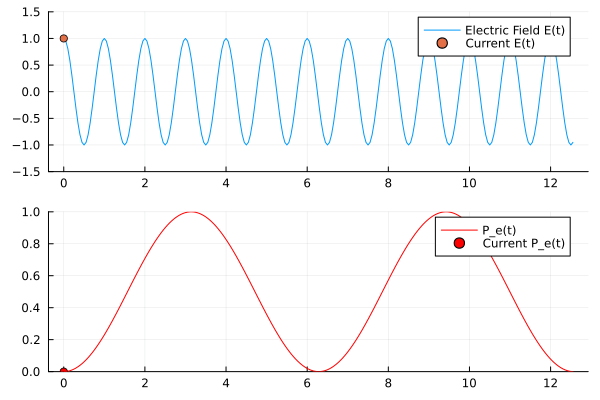

In [6]:
ω = 2π
Ω = 1.0
t_max = 4π
dt = 0.05
t = 0:dt:t_max
E(t) = cos(ω * t)  # Electric field
P_e(t) = sin(Ω * t / 2)^2  # Probability of being in the excited state |e>
anim = @animate for time in t
    p1 = plot(t, E.(t), label="Electric Field E(t)", ylims=(-1.5, 1.5))
    plot!(p1, [time], [E(time)], seriestype=:scatter, label="Current E(t)", legend=:topright)
    p2 = plot(t, P_e.(t), color=:red, label="P_e(t)", ylims=(0, 1))
    plot!(p2, [time], [P_e(time)], seriestype=:scatter, color=:red, label="Current P_e(t)", legend=:topright)
    plot(p1, p2, layout=(2,1), legend=:topright)
end
gif(anim, "RWA_animation.gif", fps = 15)


## Saturation and Power Broadening

When an atom absorbs light to the extent that its higher energy states are significantly populated, further absorption can no longer increase proportionally—this is saturation. As you increase the light's intensity, not only does saturation occur, but also the observed spectral lines of the atom broaden, a phenomenon known as power broadening. 

Power broadening can be understood as the "blurring" of atomic energy levels due to increased interaction energy with the light field. As the intensity of the light increases, the precise energy levels of the atom become less distinct, leading to broader spectral lines.
Matematically this is:

$$
     I_s = \frac{\hbar \omega_0 \Gamma}{2 \sigma}, \qquad \Gamma' = \Gamma \sqrt{1 + \frac{I}{I_s}}
$$

$ I_s $ is saturation intensity, $ \Gamma $ is the spontaneous emission rate, $ I $ is light intensity, $ \sigma $ is the absorption cross-section.


## Broading Mechanisms

Understanding how cross sections vary with frequency allows to optimize interactions for specific transitions. Broadening mechanisms like Doppler broadening are particularly important in molecule cooling, where thermal velocities of the molecules can lead to significant inhomogeneous line broadening.
$$
    \sigma(\omega) = \frac{\sigma_0}{1 + 4(\Delta/\Gamma)^2} \qquad 
    \Delta \omega_D = \omega_0 \sqrt{\frac{8k_BT \ln 2}{mc^2}}
$$

┌ Info: Saved animation to /Users/jose/Documents/Study/PhD/1.2/AMO/notes/amo1/lorentzian_power_broadening.gif
└ @ Plots /Users/jose/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/jose/Documents/Study/PhD/1.2/AMO/notes/amo1/lorentzian_power_broadening.gif")
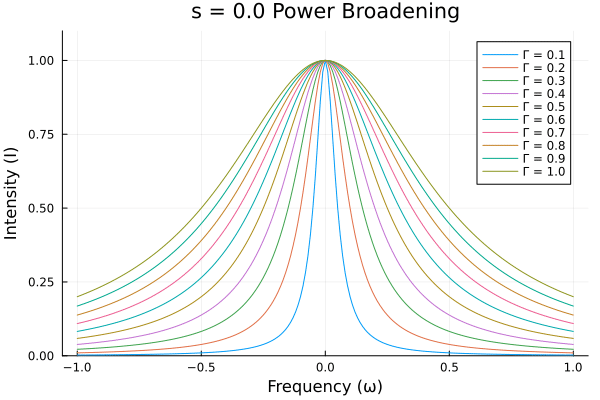

In [20]:
function lorentzian_intensity(ω, ω0, Γ, s)
    Γ_prime = Γ * sqrt(1 + s)  # Power broadening
    I0 = 1  # Normalized peak intensity
    return I0 / (1 + s + 4 * ((ω - ω0) / Γ_prime)^2)
end

ω0 = 0.0  # Center frequency of the transition
Γs = 0.1:0.1:1.0  # Different values of the natural linewidth
ω_range = -1:0.01:1  # Frequency range for the plot

anim = @animate for s in 0:0.05:5
    plot()
    for Γ in Γs
    plot!(ω_range, [lorentzian_intensity(ω, ω0, Γ, s) for ω in ω_range],
         label = "Γ = $(round(Γ, digits=1))",
         xlabel = "Frequency (ω)",
         ylabel = "Intensity (I)",
         title = "s = $(round(s, digits=1)) Power Broadening",
         ylims = (0, 1.1))
    end
end every 10
gif(anim, "lorentzian_power_broadening.gif", fps = 2)

## OBEs



┌ Info: Saved animation to /Users/jose/Documents/Study/PhD/1.2/AMO/notes/amo1/obe_animation.gif
└ @ Plots /Users/jose/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/jose/Documents/Study/PhD/1.2/AMO/notes/amo1/obe_animation.gif")
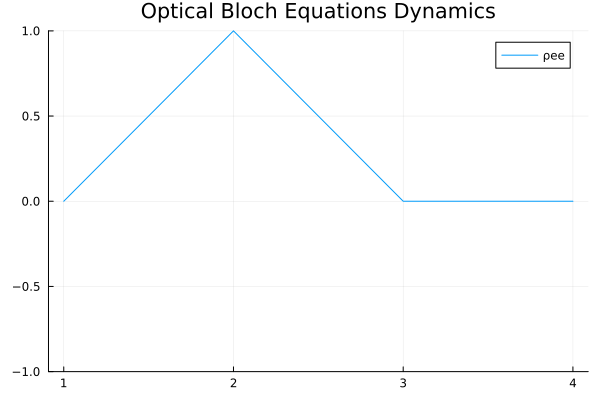

In [26]:
using DifferentialEquations

function optical_bloch_eqs!(du, u, p, t)
    ρee, ρgg, ρge, ρeg = u
    Δ, γ, Ω = p
    # Population equations
    du[1] = -γ * ρee + im * Ω * (ρeg - ρge) # dρee/dt
    du[2] = γ * ρee - im * Ω * (ρeg - ρge)  # dρgg/dt
    # Coherence equations
    du[3] = -(im * Δ + γ / 2) * ρge + im * Ω * (ρee - ρgg) # dρge/dt
    du[4] = -(im * Δ + γ / 2) * ρeg + im * Ω * (ρgg - ρee) # dρeg/dt
end
#  detuning, decay rate, Rabi frequency
params = (Δ = π, γ = 2π * 0.1, Ω = 2π * 0.1)

u0 = [0.0, 1.0, 0.0 + 0.0im, 0.0 + 0.0im] # Initially all population in ground state

tspan = (0.0, 100.0)
# Solve the OBEs
prob = ODEProblem(optical_bloch_eqs!, u0, tspan, params)
sol = solve(prob, Tsit5())

anim = @animate for i in 1:length(sol.t)
    plot(real.(sol[:,i]), label=["ρee" "ρgg" "Real(ρge)" "Real(ρeg)"], title="Optical Bloch Equations Dynamics", ylims=(-1, 1))
end

gif(anim, "obe_animation.gif", fps = 15)


# Wavefunction Montecarlo

Optical Bloch Equations (OBEs)

Optical Bloch Equations describe the dynamics of a quantum two-level system interacting with an external optical field. The system is usually characterized by its density matrix $\rho\), which evolves according to:
$$ \frac{d\rho}{dt} = -\frac{i}{\hbar} [H, \rho] + \mathcal{L}(\rho) $$
Where:
- $H$ is the Hamiltonian of the system.
- $\mathcal{L}(\rho)$ represents the Lindblad superoperator describing the system's interaction with the environment (e.g., spontaneous emission).

#### Discretization and Numerical Integration
1. **Hamiltonian Formulation**: Start by defining the Hamiltonian of your two-level system. In the presence of a driving laser field, you can write:
   $$ H = \hbar \omega_0 \sigma_z + \hbar \Omega (\sigma_+ e^{-i \omega t} + \sigma_- e^{i \omega t}) $$
   Where $\omega_0$ is the resonant frequency, $\Omega$ is the Rabi frequency, and $\sigma_+$, $\sigma_-$, and $\sigma_z$ are the Pauli matrices.

2. **Lindblad Terms**: Include relaxation processes like spontaneous emission:
   $$ \mathcal{L}(\rho) = \gamma (2 \sigma_- \rho \sigma_+ - \sigma_+ \sigma_- \rho - \rho \sigma_+ \sigma_-) $$

3. **Numerical Integration**: Use a numerical integrator like the Runge-Kutta method (e.g., RK4) to solve the differential equation. This involves discretizing the time into small steps and iteratively calculating the density matrix $\rho\).

### Wavefunction Monte Carlo Simulation

1. **Wavefunction Initialization**: Start with an initial state $ |\psi(0)\rangle $.

2. **Hamiltonian Evolution**: Between jumps, evolve the state using the non-Hermitian effective Hamiltonian:
   $$ H_{\text{eff}} = H - \frac{i\hbar}{2} \sum_k C_k^\dagger C_k $$
   Where $C_k$ are the jump operators corresponding to different decay processes.

3. **Jump Timing**: Determine the time $t$ for a quantum jump to occur. This is typically done by generating a random number $ r $ and solving:
   $$ \int_0^t dt' \|\langle \psi(t')| C_k^\dagger C_k | \psi(t') \rangle\| = -\ln(r) $$

4. **State Update After Jump**: When a jump occurs, update the state according to:
   $$ |\psi(t)\rangle = \frac{C_k |\psi(t^-)\rangle}{\| C_k |\psi(t^-)\rangle \|} $$

5. **Repeat**: Continue the process, alternating between deterministic evolution under $H_{\text{eff}}$ and stochastic jumps, until the desired final time is reached.